In [2]:
# Attempt at blob detection in 3d images
import skimage as sk
import numpy as np
from skimage import io
from skimage import feature
import pandas as pd
from scipy.spatial import distance as dist
import scipy.cluster.hierarchy as hier
import matplotlib.pyplot as plt
%matplotlib inline

img_file = '/Users/jake/Desktop/SampleGFP.tif'
img_raw = sk.io.imread(img_file)

In [9]:
# 3D Blob Detection Functions
# takes image, min_sigma (affects minimum cell size found), max_sigma (affects max cell size found),
# threshold (affects how bright cells must be to be detected)

# These do NOT perform blob detection in 3D. Rather, they perform 2D blob detection across all planes of the image
# and return an array of y, x, size, z

# Laplacian of Gaussian
def detect_blobs_3dlog(image, min_sigma=10, max_sigma=20, threshold=.003): 
    """skimage.feature.blob_log documentation:
    Finds blobs in the given grayscale image.

    Blobs are found using the Laplacian of Gaussian (LoG) method [1]_.
    For each blob found, the method returns its coordinates and the standard
    deviation of the Gaussian kernel that detected the blob.

    Parameters
    ----------
    image : ndarray
        Input grayscale image, blobs are assumed to be light on dark
        background (white on black).
    min_sigma : float, optional
        The minimum standard deviation for Gaussian Kernel. Keep this low to
        detect smaller blobs.
    max_sigma : float, optional
        The maximum standard deviation for Gaussian Kernel. Keep this high to
        detect larger blobs.
    num_sigma : int, optional
        The number of intermediate values of standard deviations to consider
        between `min_sigma` and `max_sigma`.
    threshold : float, optional.
        The absolute lower bound for scale space maxima. Local maxima smaller
        than thresh are ignored. Reduce this to detect blobs with less
        intensities.
    overlap : float, optional
        A value between 0 and 1. If the area of two blobs overlaps by a
        fraction greater than `threshold`, the smaller blob is eliminated.
    log_scale : bool, optional
        If set intermediate values of standard deviations are interpolated
        using a logarithmic scale to the base `10`. If not, linear
        interpolation is used.

    Returns
    -------
    A : (n, 3) ndarray
        A 2d array with each row representing 3 values, ``(y,x,sigma)``
        where ``(y,x)`` are coordinates of the blob and ``sigma`` is the
        standard deviation of the Gaussian kernel which detected the blob.

    References
    ----------
    .. [1] http://en.wikipedia.org/wiki/Blob_detection#The_Laplacian_of_Gaussian
    """
    for i in range(len(image)):
        # the if statement is necessary to create the proper array on the first iteration
        if i == 0:
            log_cells = sk.feature.blob_log(image[0,:,:], min_sigma = min_sigma, max_sigma = max_sigma, 
                                            threshold = threshold)
            log_cells = np.column_stack((log_cells, np.ones((len(log_cells)))))
        else:
            new_cells = sk.feature.blob_log(image[i,:,:], min_sigma = min_sigma, max_sigma = max_sigma, 
                                            threshold = threshold)
            new_cells = np.column_stack((new_cells, np.full((len(new_cells)), i+1)))
            log_cells = np.concatenate((log_cells, new_cells))
    return log_cells

# Determinant of Hessian
def detect_blobs_3dhess(image, min_sigma=10, max_sigma=20, threshold=.00008):
    
    """skimage.feature.blob_doh documentation:
    Finds blobs in the given grayscale image.

    Blobs are found using the Determinant of Hessian method [1]_. For each blob
    found, the method returns its coordinates and the standard deviation
    of the Gaussian Kernel used for the Hessian matrix whose determinant
    detected the blob. Determinant of Hessians is approximated using [2]_.

    Parameters
    ----------
    image : ndarray
        Input grayscale image.Blobs can either be light on dark or vice versa.
    min_sigma : float, optional
        The minimum standard deviation for Gaussian Kernel used to compute
        Hessian matrix. Keep this low to detect smaller blobs.
    max_sigma : float, optional
        The maximum standard deviation for Gaussian Kernel used to compute
        Hessian matrix. Keep this high to detect larger blobs.
    num_sigma : int, optional
        The number of intermediate values of standard deviations to consider
        between `min_sigma` and `max_sigma`.
    threshold : float, optional.
        The absolute lower bound for scale space maxima. Local maxima smaller
        than thresh are ignored. Reduce this to detect less prominent blobs.
    overlap : float, optional
        A value between 0 and 1. If the area of two blobs overlaps by a
        fraction greater than `threshold`, the smaller blob is eliminated.
    log_scale : bool, optional
        If set intermediate values of standard deviations are interpolated
        using a logarithmic scale to the base `10`. If not, linear
        interpolation is used.

    Returns
    -------
    A : (n, 3) ndarray
        A 2d array with each row representing 3 values, ``(y,x,sigma)``
        where ``(y,x)`` are coordinates of the blob and ``sigma`` is the
        standard deviation of the Gaussian kernel of the Hessian Matrix whose
        determinant detected the blob.

    References
    ----------
    .. [1] http://en.wikipedia.org/wiki/Blob_detection#The_determinant_of_the_Hessian

    .. [2] Herbert Bay, Andreas Ess, Tinne Tuytelaars, Luc Van Gool,
           "SURF: Speeded Up Robust Features"
           ftp://ftp.vision.ee.ethz.ch/publications/articles/eth_biwi_00517.pdf
    """
    for i in range(len(image)):
        # the if statement is necessary to create the proper array on the first iteration
        if i == 0:
            hess_cells = sk.feature.blob_doh(image[0,:,:], min_sigma = min_sigma,
                                                        max_sigma = max_sigma, threshold = threshold)
            hess_cells = np.column_stack((hess_cells, np.ones((len(hess_cells)))))
        else:
            new_cells = sk.feature.blob_doh(image[i,:,:], min_sigma = min_sigma,
                                                        max_sigma = max_sigma, threshold = threshold)
            new_cells = np.column_stack((new_cells, np.full((len(new_cells)), i+1)))
            hess_cells = np.concatenate((hess_cells, new_cells))
    return hess_cells

# Difference of Gaussian
def detect_blobs_3ddog(image, min_sigma=10, max_sigma=20, threshold=.003):
    """skimage.feature.blob_dog documentation:
    Finds blobs in the given grayscale image.

    Blobs are found using the Difference of Gaussian (DoG) method [1]_.
    For each blob found, the method returns its coordinates and the standard
    deviation of the Gaussian kernel that detected the blob.

    Parameters
    ----------
    image : ndarray
        Input grayscale image, blobs are assumed to be light on dark
        background (white on black).
    min_sigma : float, optional
        The minimum standard deviation for Gaussian Kernel. Keep this low to
        detect smaller blobs.
    max_sigma : float, optional
        The maximum standard deviation for Gaussian Kernel. Keep this high to
        detect larger blobs.
    sigma_ratio : float, optional
        The ratio between the standard deviation of Gaussian Kernels used for
        computing the Difference of Gaussians
    threshold : float, optional.
        The absolute lower bound for scale space maxima. Local maxima smaller
        than thresh are ignored. Reduce this to detect blobs with less
        intensities.
    overlap : float, optional
        A value between 0 and 1. If the area of two blobs overlaps by a
        fraction greater than `threshold`, the smaller blob is eliminated.

    Returns
    -------
    A : (n, 3) ndarray
        A 2d array with each row representing 3 values, ``(y,x,sigma)``
        where ``(y,x)`` are coordinates of the blob and ``sigma`` is the
        standard deviation of the Gaussian kernel which detected the blob.

    References
    ----------
    .. [1] http://en.wikipedia.org/wiki/Blob_detection#The_difference_of_Gaussians_approach"""
    
    for i in range(len(image)):
        # the if statement is necessary to create the proper array on the first iteration
        if i == 0:
            dog_cells = sk.feature.blob_dog(image[0,:,:], min_sigma = min_sigma,
                                                        max_sigma = max_sigma, threshold = threshold)
            dog_cells = np.column_stack((dog_cells, np.ones((len(dog_cells)))))
        else:
            new_cells = sk.feature.blob_dog(image[i,:,:], min_sigma = min_sigma,
                                                        max_sigma = max_sigma, threshold = threshold)
            new_cells = np.column_stack((new_cells, np.full((len(new_cells)), i+1)))
            dog_cells = np.concatenate((dog_cells, new_cells))
    return dog_cells

In [13]:
# Function for performing unsupervised clustering of centroids to get a single centroid for each cell.
# takes vector of x values, vector of y values, and the maximum distance btwn centroids that form a cluster.

def cluster_centroids(x, y, max_dist):
    
    """scipy.cluster.hierarchy documentation:
    Forms flat clusters from the hierarchical clustering defined by
    the given linkage matrix.

    Parameters
    ----------
    Z : ndarray
        The hierarchical clustering encoded with the matrix returned
        by the `linkage` function.
    t : float
        The threshold to apply when forming flat clusters.
    criterion : str, optional
        The criterion to use in forming flat clusters. This can
        be any of the following values:

          ``inconsistent`` : If a cluster node and all its
              descendants have an inconsistent value less than or equal
              to `t` then all its leaf descendants belong to the
              same flat cluster. When no non-singleton cluster meets
              this criterion, every node is assigned to its own
              cluster. (Default)

          ``distance`` : Forms flat clusters so that the original
              observations in each flat cluster have no greater a
              cophenetic distance than `t`.

          ``maxclust`` : Finds a minimum threshold ``r`` so that
              the cophenetic distance between any two original
              observations in the same flat cluster is no more than
              ``r`` and no more than `t` flat clusters are formed.

          ``monocrit`` : Forms a flat cluster from a cluster node c
              with index i when ``monocrit[j] <= t``.

              For example, to threshold on the maximum mean distance
              as computed in the inconsistency matrix R with a
              threshold of 0.8 do::

                  MR = maxRstat(Z, R, 3)
                  cluster(Z, t=0.8, criterion='monocrit', monocrit=MR)

          ``maxclust_monocrit`` : Forms a flat cluster from a
              non-singleton cluster node ``c`` when ``monocrit[i] <=
              r`` for all cluster indices ``i`` below and including
              ``c``. ``r`` is minimized such that no more than ``t``
              flat clusters are formed. monocrit must be
              monotonic. For example, to minimize the threshold t on
              maximum inconsistency values so that no more than 3 flat
              clusters are formed, do::

                  MI = maxinconsts(Z, R)
                  cluster(Z, t=3, criterion='maxclust_monocrit', monocrit=MI)

    depth : int, optional
        The maximum depth to perform the inconsistency calculation.
        It has no meaning for the other criteria. Default is 2.
    R : ndarray, optional
        The inconsistency matrix to use for the 'inconsistent'
        criterion. This matrix is computed if not provided.
    monocrit : ndarray, optional
        An array of length n-1. `monocrit[i]` is the
        statistics upon which non-singleton i is thresholded. The
        monocrit vector must be monotonic, i.e. given a node c with
        index i, for all node indices j corresponding to nodes
        below c, ``monocrit[i] >= monocrit[j]``.

    Returns
    -------
    fcluster : ndarray
        An array of length ``n``. ``T[i]`` is the flat cluster number to
        which original observation ``i`` belongs."""
    
    xy_array = np.column_stack((x,y))
    coordinates = pd.DataFrame(xy_array, columns = ['x','y'])
    
    #create matrix of distances between all centroids
    dist_mat = dist.squareform(dist.pdist(coordinates.values))
    
    #perform clustering
    link_mat = hier.linkage(dist_mat)
    cluster_idx = hier.fcluster(link_mat, max_dist, criterion = 'distance')
    
    #make organized dataframe with labeled clusters
    coordinates['new_label'] = cluster_idx
    coordinates.set_index('new_label', drop=True, append=False, inplace=True)
    coordinates.index.name = 'label'
    coordinates = coordinates.sort_index()
    
    #compute a final centroid for each cell by averaging the x y coords of each cluster
    coordinates = coordinates.groupby(level ='label').mean()
    return coordinates

In [14]:
def plot_blobs(blobs, color, size_mod, fill = True):
    for blob in blobs:
        y, x, size = blob
        c = plt.Circle((x, y), size*size_mod, color=color, linewidth=2, fill=fill)
        ax.add_patch(c)
        

/Users/jake/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:85: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


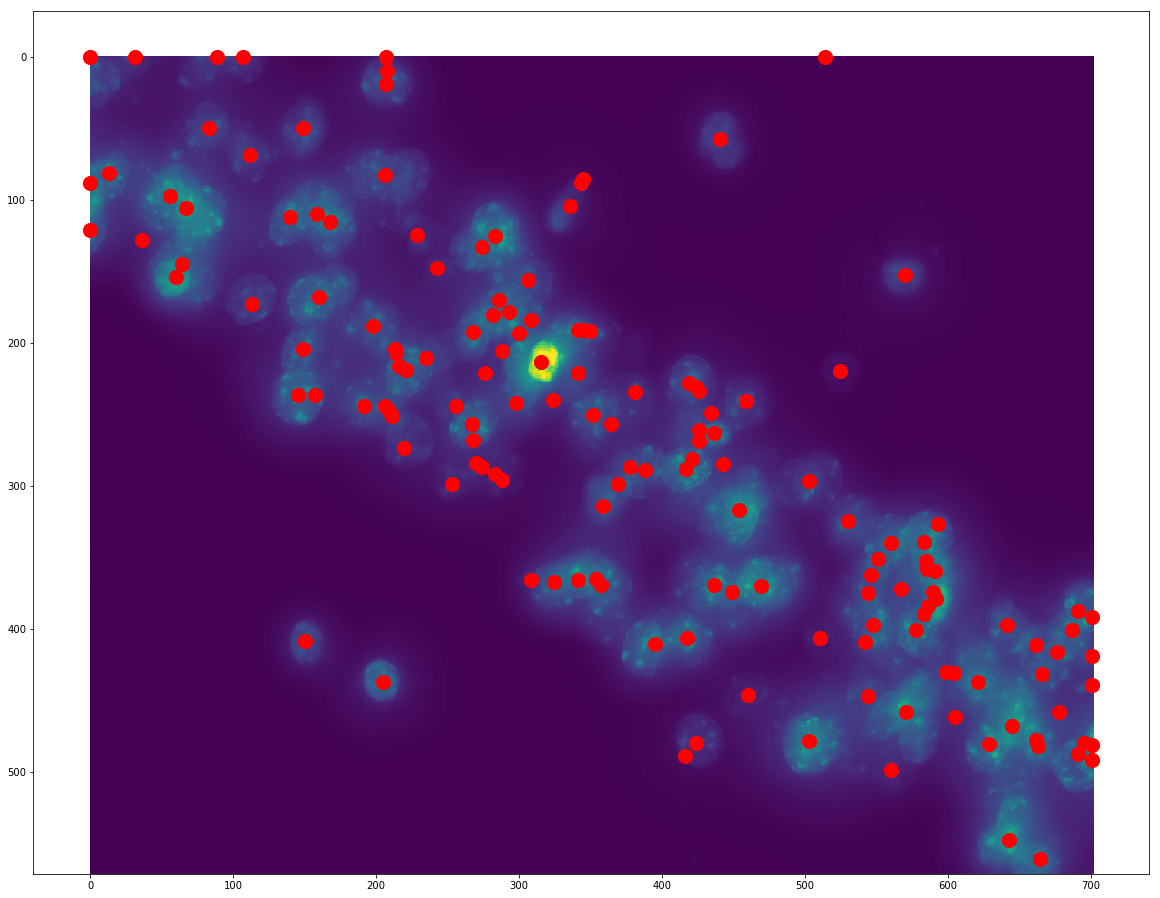

In [15]:
# Example pipeline

# 3 separate blob detections
log_cells = detect_blobs_3dlog(img_raw)
dog_cells = detect_blobs_3ddog(img_raw)
hess_cells = detect_blobs_3dhess(img_raw)

# place into one array
all_cells = np.concatenate((log_cells, dog_cells, hess_cells))

# cluster centroids
final_cells = cluster_centroids(all_cells[:,1], all_cells[:,0], 100)

# Plotting
# Plot on top of max intensity z projection
img_max = img_raw.max(axis=0)
f, ax = plt.subplots(1, figsize = (20,20))
plt.imshow(img_max)
plt.scatter(final_cells['x'], final_cells['y'], 200,  'r')